In [2]:
library(phyloseq)
library(ggplot2)
library(vegan)
library(readr)
library(data.table)
library(dplyr)
library(stats)
library(ggpubr)
library(dunn.test)
library(viridis)

In [3]:
bmp_nt = readRDS("/home/holutz/projects/BirdMP/RDSfiles/birdmp_nt.rds") #non-transformed
bmp_t = readRDS("/home/holutz/projects/BirdMP/RDSfiles/birdmp_t.rds") #transformed for relative abundance

In [33]:
bmp_nt
bmp_nt.rare #rarefied to 1000 read depth

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 37178 taxa and 2009 samples ]
sample_data() Sample Data:       [ 2009 samples by 41 sample variables ]
tax_table()   Taxonomy Table:    [ 37178 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 37178 tips and 37176 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 22679 taxa and 1982 samples ]
sample_data() Sample Data:       [ 1982 samples by 41 sample variables ]
tax_table()   Taxonomy Table:    [ 22679 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 22679 tips and 22677 internal nodes ]

In [56]:
bmp.df = data.frame(sample_data(bmp_nt))
colnames(bmp.df)
bmp.df %>% group_by(SampleType) %>% summarize(count=n())

[1] "X.SampleID"                 "BarcodeSequence"           
 [3] "LinkerPrimerSequence"       "Plate_name"                
 [5] "allplatesbarcodes_Tissue"   "System"                    
 [7] "System_gut_unique_GI_GI"    "System_gut_unique_GI_fecal"
 [9] "SampleType"                 "submitedsampename"         
[11] "Field_No1"                  "FMNH_no"                   
[13] "Sex"                        "Order"                     
[15] "Family"                     "Genus"                     
[17] "Species"                    "Species_name"              
[19] "Subspecies"                 "COMMON_NAME"               
[21] "habitat_num"                "FIELD_SITE"                
[23] "NEST_TYPE"                  "NEST_LOCATION"             
[25] "NESTING_HABITS"             "SOCIAL_SYSTEM"             
[27] "DIET"                       "Field40"                   
[29] "STRATA"                     "MIGRATORY_STATUS"          
[31] "SEXUAL_DIMORPHISM"          "Description"               
[33] "HaemoproteusHap"            "PlasmodiumHaplotype"       
[35] "LeucocytozoonHap"           "Uninfected"                
[37] "CoinfectionHap"             "CoinfectionCode"           
[39] "COMBO"                      "HaemStatus"                
[41] "InfectionStatus"

`summarise()` ungrouping output (override with `.groups` argument)



SampleType,count
<fct>,<int>
Blood,727
Buccal,364
Buccal_Fecal_Swab,228
Crop,9
Crop_Gizzard,1
Fecal,383
GI,221
Gizzard,47
Liver,13


### Alphadiversity

#### Shannon Index

In [53]:
sha = estimate_richness(bmp_nt, split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)
sha[] <- lapply(sha, gsub, pattern='X', replacement='') #Remove X from 'X.SampleID'

sample_tab = data.frame(sample_data(bmp_nt))
names(sample_tab)[1] = "SampleID"

dfsha = merge(sha, sample_tab, on="SampleID")

dfsha$Shannon = as.numeric(dfsha$Shannon)

stats = dfsha %>%
    group_by(SampleType) %>%
    summarize(median = median(Shannon),
              mean = mean(Shannon),
              sd = sd(Shannon),
              sem = sd(Shannon/sqrt(length(Shannon)))) %>%
    arrange(-desc(mean))
stats

`summarise()` ungrouping output (override with `.groups` argument)



SampleType,median,mean,sd,sem
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Blood,1.737946,1.760093,0.6289911,0.02332799
GI,1.562806,1.856606,1.3536055,0.09105336
Spleen,1.843487,1.914316,0.8490308,0.21225770
Crop,1.992287,2.076738,0.6095517,0.20318388
Gizzard,2.233075,2.131603,1.1554010,0.16853255
Crop_Gizzard,2.323358,2.323358,NA,NA
Buccal_Fecal_Swab,2.398766,2.390408,0.7975102,0.05281640
Fecal,2.523208,2.433950,1.0089058,0.05155268
Liver,2.516671,2.602117,1.6689331,0.46287875


In [54]:
#CHECK FOR SIGNIFICANCE
stats.krusk = kruskal.test(Shannon~SampleType, data=dfsha)
stats.krusk

#POST-HOC ANALYSIS
dunn = dunn.test(dfsha$Shannon, g=dfsha$SampleType, method="bonferroni")
dunn


	Kruskal-Wallis rank sum test

data:  Shannon by SampleType
Kruskal-Wallis chi-squared = 337.07, df = 9, p-value < 2.2e-16


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 337.0723, df = 9, p-value = 0


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |      Blood     Buccal   Buccal_F       Crop   Crop_Giz      Fecal
---------+------------------------------------------------------------------
  Buccal |  -15.83951
         |    0.0000*
         |
Buccal_F |  -9.489069   3.513842
         |    0.0000*    0.0099*
         |
    Crop |  -1.112549   1.908245   1.021407
         |     1.0000     1.0000     1.0000
         |
Crop_Giz |  -0.747277   0.268875  -0.027468  -0.355426
         |     1.0000     1.0000     1.0000     1.0000
         |
   Fecal |  -11.62885   3.863476  -0.166980  -1.070766   0.013543
         |    0.0000*    0.0025*     1.0000     1.0000     1.0000
         |
      GI |  -1.575630   10.50701   6.347973   0.741377   0.625347   7

$chi2
[1] 337.0723

$Z
 [1] -15.83951009  -9.48906937   3.51384283  -1.11254984   1.90824524
 [6]   1.02140749  -0.74727740   0.26887551  -0.02746870  -0.35542684
[11] -11.62885938   3.86347683  -0.16698044  -1.07076655   0.01354368
[16]  -1.57563092  10.50701586   6.34797396   0.74137794   0.62534731
[21]   7.25903044  -3.00382160   3.64487464   1.67400932  -0.21699900
[26]   0.29260104   1.82546170  -2.06104956  -2.23832364   1.38422562
[31]   0.32943358  -0.58387868   0.11704757   0.38261645  -1.77053484
[36]  -0.55599577  -0.75523783   3.23432018   2.04694102   0.43743011
[41]   0.54028723   2.12939282  -0.26978543   0.90248828   1.16619263

$P
 [1] 8.305496e-57 1.165530e-21 2.208370e-04 1.329509e-01 2.817976e-02
 [6] 1.535307e-01 2.274481e-01 3.940127e-01 4.890430e-01 3.611349e-01
[11] 1.469999e-31 5.589225e-05 4.336927e-01 1.421372e-01 4.945970e-01
[16] 5.755544e-02 4.009546e-26 1.090845e-10 2.292322e-01 2.658716e-01
[21] 1.949374e-13 1.333058e-03 1.337611e-04 4.706438e-02 4.141046e-01
[26] 3.849136e-01 3.396569e-02 1.964916e-02 1.259998e-02 8.314469e-02
[31] 3.709140e-01 2.796510e-01 4.534112e-01 3.510021e-01 3.831904e-02
[36] 2.891069e-01 2.250531e-01 6.096634e-04 2.033194e-02 3.308997e-01
[41] 2.944995e-01 1.661089e-02 3.936627e-01 1.833988e-01 1.217683e-01

$P.adjusted
 [1] 3.737473e-55 5.244885e-20 9.937666e-03 1.000000e+00 1.000000e+00
 [6] 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00
[11] 6.614994e-30 2.515151e-03 1.000000e+00 1.000000e+00 1.000000e+00
[16] 1.000000e+00 1.804295e-24 4.908802e-09 1.000000e+00 1.000000e+00
[21] 8.772181e-12 5.998761e-02 6.019249e-03 1.000000e+00 1.000000e+00
[26] 1.000000e+00 1.000000e+00 8.842120e-01 5.669991e-01 1.000000e+00
[31] 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00
[36] 1.000000e+00 1.000000e+00 2.743485e-02 9.149372e-01 1.000000e+00
[41] 1.000000e+00 7.474899e-01 1.000000e+00 1.000000e+00 1.000000e+00

$comparisons
 [1] "Blood - Buccal"                   "Blood - Buccal_Fecal_Swab"       
 [3] "Buccal - Buccal_Fecal_Swab"       "Blood - Crop"                    
 [5] "Buccal - Crop"                    "Buccal_Fecal_Swab - Crop"        
 [7] "Blood - Crop_Gizzard"             "Buccal - Crop_Gizzard"           
 [9] "Buccal_Fecal_Swab - Crop_Gizzard" "Crop - Crop_Gizzard"             
[11] "Blood - Fecal"                    "Buccal - Fecal"                  
[13] "Buccal_Fecal_Swab - Fecal"        "Crop - Fecal"                    
[15] "Crop_Gizzard - Fecal"             "Blood - GI"                      
[17] "Buccal - GI"                      "Buccal_Fecal_Swab - GI"          
[19] "Crop - GI"                        "Crop_Gizzard - GI"               
[21] "Fecal - GI"                       "Blood - Gizzard"                 
[23] "Buccal - Gizzard"                 "Buccal_Fecal_Swab - Gizzard"     
[25] "Crop - Gizzard"                   "Crop_Gizzard - Gizzard"          
[27] "Fecal - Gizzard"                  "GI - Gizzard"                    
[29] "Blood - Liver"                    "Buccal - Liver"                  
[31] "Buccal_Fecal_Swab - Liver"        "Crop - Liver"                    
[33] "Crop_Gizzard - Liver"             "Fecal - Liver"                   
[35] "GI - Liver"                       "Gizzard - Liver"                 
[37] "Blood - Spleen"                   "Buccal - Spleen"                 
[39] "Buccal_Fecal_Swab - Spleen"       "Crop - Spleen"                   
[41] "Crop_Gizzard - Spleen"            "Fecal - Spleen"                  
[43] "GI - Spleen"                      "Gizzard - Spleen"                
[45] "Liver - Spleen"

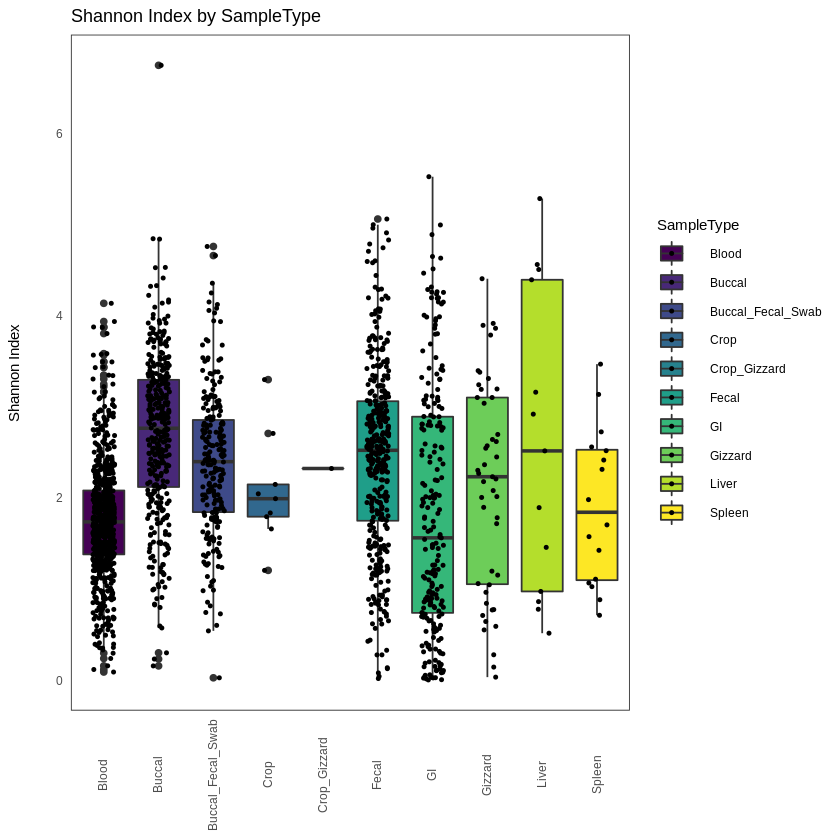

In [55]:
p = ggplot(dfsha, aes(x = SampleType, y = Shannon, fill = SampleType)) + ggtitle("Shannon Index by SampleType")

p = p + geom_boxplot() + ylab("Shannon Index") +
    scale_fill_viridis(option="viridis", discrete=TRUE, direction=1)

p = p + geom_point(size = .75,  
                   position = position_jitter(h = 0, w = 0.2))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=9, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              axis.text.x=element_text(angle=90,vjust=0.4),
              #legend.key.size = unit(.25, "mm"),
              legend.spacing.x = unit(.2,"in"),
              axis.title.x=element_blank())
p

#### Observed Richness

In [57]:
obs = estimate_richness(bmp_nt, split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)
obs[] <- lapply(obs, gsub, pattern='X', replacement='') #Remove X from SampleID name

sample_tab = data.frame(sample_data(bmp_nt))
names(sample_tab)[1] = "SampleID"

dfobs = merge(obs, sample_tab, on="SampleID")

dfobs$Observed = as.numeric(dfobs$Observed)

stats = dfobs %>%
    group_by(SampleType) %>%
    summarize(median = median(Observed),
              mean = mean(Observed),
              sd = sd(Observed),
              sem = sd(Observed/sqrt(length(Observed)))) %>%
    arrange(-desc(mean))
stats

`summarise()` ungrouping output (override with `.groups` argument)



SampleType,median,mean,sd,sem
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Buccal_Fecal_Swab,64.0,87.45175,83.86596,5.554159
Blood,81.0,95.78680,65.09717,2.414320
Fecal,57.0,100.29243,111.21807,5.682978
Buccal,91.0,126.61538,145.72813,7.638230
GI,126.0,196.69683,218.59960,14.704600
Gizzard,185.0,242.68085,194.25131,28.334465
Spleen,192.5,245.31250,185.45897,46.364742
Crop,136.0,266.44444,274.07668,91.358894
Crop_Gizzard,274.0,274.00000,NA,NA


In [59]:
#CHECK FOR SIGNIFICANCE
stats.krusk = kruskal.test(Observed~SampleType, data=dfobs)
stats.krusk

#POST-HOC ANALYSIS
dunn = dunn.test(dfobs$Observed, g=dfobs$SampleType, method="bonferroni")
dunn


	Kruskal-Wallis rank sum test

data:  Observed by SampleType
Kruskal-Wallis chi-squared = 182.36, df = 9, p-value < 2.2e-16


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 182.3564, df = 9, p-value = 0


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |      Blood     Buccal   Buccal_F       Crop   Crop_Giz      Fecal
---------+------------------------------------------------------------------
  Buccal |  -3.347493
         |    0.0183*
         |
Buccal_F |   3.899468   6.049433
         |    0.0022*    0.0000*
         |
    Crop |  -2.627140  -1.974278  -3.463613
         |     0.1937     1.0000    0.0120*
         |
Crop_Giz |  -1.491500  -1.275836  -1.784603  -0.580033
         |     1.0000     1.0000     1.0000     1.0000
         |
   Fecal |   4.486482   6.806142  -0.152026   3.452830   1.773482
         |    0.0002*    0.0000*     1.0000    0.0125*     1.0000
         |
      GI |  -5.317618  -2.269426  -7.462658   1.389929   1.081614  -8

$chi2
[1] 182.3564

$Z
 [1] -3.34749305  3.89946843  6.04943367 -2.62714086 -1.97427869 -3.46361384
 [7] -1.49150095 -1.27583659 -1.78460395 -0.58003344  4.48648247  6.80614274
[13] -0.15202690  3.45283001  1.77348284 -5.31761844 -2.26942608 -7.46265819
[19]  1.38992918  1.08161410 -8.18877207 -6.06963062 -4.50706590 -7.55017909
[25] -0.08904598  0.57294635 -7.74338763 -3.14420729 -3.48401485 -2.69239843
[31] -4.45692270 -0.21625762  0.49880396 -4.46129008 -1.98473427 -0.19585935
[37] -4.42383869 -3.53562983 -5.46760842 -0.56867064  0.36328231 -5.49179745
[43] -2.74089795 -0.70669324 -0.38343012

$P
 [1] 4.077302e-04 4.820205e-05 7.267795e-10 4.305284e-03 2.417503e-02
 [6] 2.664855e-04 6.791501e-02 1.010066e-01 3.716279e-02 2.809460e-01
[11] 3.620434e-06 5.012513e-12 4.395829e-01 2.773692e-04 3.807437e-02
[16] 5.256712e-08 1.162121e-02 4.239706e-14 8.227519e-02 1.397120e-01
[21] 1.319524e-16 6.410239e-10 3.286511e-06 2.173301e-14 4.645227e-01
[26] 2.833405e-01 4.840117e-15 8.326871e-04 2.469760e-04 3.547007e-03
[31] 4.157228e-06 4.143935e-01 3.089587e-01 4.073386e-06 2.358702e-02
[36] 4.223601e-01 4.848122e-06 2.034021e-04 2.280741e-08 2.847898e-01
[41] 3.581970e-01 1.989318e-08 3.063577e-03 2.398786e-01 3.507004e-01

$P.adjusted
 [1] 1.834786e-02 2.169092e-03 3.270508e-08 1.937378e-01 1.000000e+00
 [6] 1.199185e-02 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00
[11] 1.629195e-04 2.255631e-10 1.000000e+00 1.248162e-02 1.000000e+00
[16] 2.365521e-06 5.229546e-01 1.907868e-12 1.000000e+00 1.000000e+00
[21] 5.937858e-15 2.884608e-08 1.478930e-04 9.779853e-13 1.000000e+00
[26] 1.000000e+00 2.178053e-13 3.747092e-02 1.111392e-02 1.596153e-01
[31] 1.870753e-04 1.000000e+00 1.000000e+00 1.833024e-04 1.000000e+00
[36] 1.000000e+00 2.181655e-04 9.153097e-03 1.026333e-06 1.000000e+00
[41] 1.000000e+00 8.951930e-07 1.378610e-01 1.000000e+00 1.000000e+00

$comparisons
 [1] "Blood - Buccal"                   "Blood - Buccal_Fecal_Swab"       
 [3] "Buccal - Buccal_Fecal_Swab"       "Blood - Crop"                    
 [5] "Buccal - Crop"                    "Buccal_Fecal_Swab - Crop"        
 [7] "Blood - Crop_Gizzard"             "Buccal - Crop_Gizzard"           
 [9] "Buccal_Fecal_Swab - Crop_Gizzard" "Crop - Crop_Gizzard"             
[11] "Blood - Fecal"                    "Buccal - Fecal"                  
[13] "Buccal_Fecal_Swab - Fecal"        "Crop - Fecal"                    
[15] "Crop_Gizzard - Fecal"             "Blood - GI"                      
[17] "Buccal - GI"                      "Buccal_Fecal_Swab - GI"          
[19] "Crop - GI"                        "Crop_Gizzard - GI"               
[21] "Fecal - GI"                       "Blood - Gizzard"                 
[23] "Buccal - Gizzard"                 "Buccal_Fecal_Swab - Gizzard"     
[25] "Crop - Gizzard"                   "Crop_Gizzard - Gizzard"          
[27] "Fecal - Gizzard"                  "GI - Gizzard"                    
[29] "Blood - Liver"                    "Buccal - Liver"                  
[31] "Buccal_Fecal_Swab - Liver"        "Crop - Liver"                    
[33] "Crop_Gizzard - Liver"             "Fecal - Liver"                   
[35] "GI - Liver"                       "Gizzard - Liver"                 
[37] "Blood - Spleen"                   "Buccal - Spleen"                 
[39] "Buccal_Fecal_Swab - Spleen"       "Crop - Spleen"                   
[41] "Crop_Gizzard - Spleen"            "Fecal - Spleen"                  
[43] "GI - Spleen"                      "Gizzard - Spleen"                
[45] "Liver - Spleen"

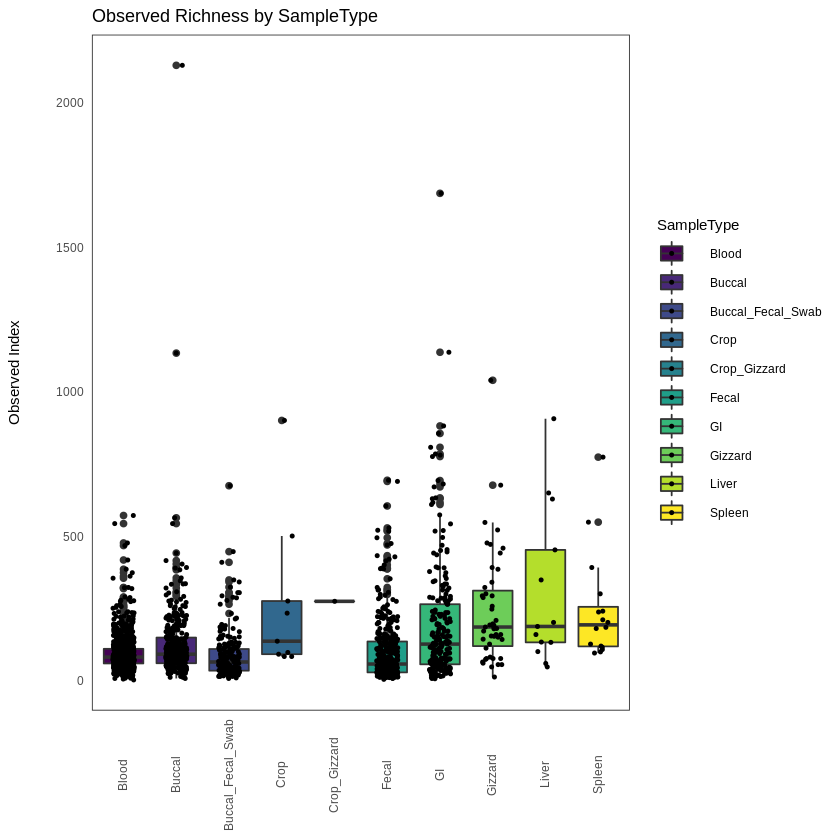

In [58]:
p = ggplot(dfobs, aes(x = SampleType, y = Observed, fill = SampleType)) + ggtitle("Observed Richness by SampleType")

p = p + geom_boxplot() + ylab("Observed Index") +
    scale_fill_viridis(option="viridis", discrete=TRUE, direction=1)

p = p + geom_point(size = .75,  
                   position = position_jitter(h = 0, w = 0.2))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=9, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              axis.text.x=element_text(angle=90,vjust=0.4),
              #legend.key.size = unit(.25, "mm"),
              legend.spacing.x = unit(.2,"in"),
              axis.title.x=element_blank())
p

### Betadiveristy

In [60]:
bmp.unif.dist = distance(bmp_t, method = "unifrac", type = "samples")
bmp.unif.dist.log = ordinate(bmp_t, method = "PCoA", distance = "unifrac")
bmp.unif.dist.evals = bmp.unif.dist.log$values$Eigenvalues
saveRDS(bmp.unif.dist, "/home/holutz/projects/BirdMP/Bdiv/bmp.unif.dist.rds")
saveRDS(bmp.unif.dist.log, "/home/holutz/projects/BirdMP/Bdiv/bmp.unif.dist.log.rds")
saveRDS(bmp.unif.dist.evals, "/home/holutz/projects/BirdMP/Bdiv/bmp.unif.dist.evals.rds")

bmp.wunif.dist = distance(bmp_t, method = "wunifrac", type = "samples")
bmp.wunif.dist.log = ordinate(bmp_t, method = "PCoA", distance = "wunifrac")
bmp.wunif.dist.evals = bmp.wunif.dist.log$values$Eigenvalues
saveRDS(bmp.wunif.dist, "/home/holutz/projects/BirdMP/Bdiv/bmp.wunif.dist.rds")
saveRDS(bmp.wunif.dist.log, "/home/holutz/projects/BirdMP/Bdiv/bmp.wunif.dist.log.rds")
saveRDS(bmp.wunif.dist.evals, "/home/holutz/projects/BirdMP/Bdiv/bmp.wunif.dist.evals.rds")

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGGAGGGTGCAAGCGTTATCCGGATTCACTGGGTTTAAAGGGAGCGTAGGAGGGCAGGTAAGTCAGTGGTGAAATCTTCGAGCTTAACTCGGAAACTGCCGTTGATACTATCTGTCTTGAATGCCGTGGAGATGAGCGGAATATGTCA -- in the phylogenetic tree in the data you provided.”
Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACAGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTTGTTAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGATACTGGCAAGCTAGAGTATGGGAGAGGATGGTAGAATTCCAGG -- in the phylogenetic tree in the data you provided.”
Warning message in UniFrac(physeq, weighted = TRUE, ...):
“Randomly assigning root as -- TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGTTATACAAGTCTGGAGTGAAAGCCCGGGGCTCAACCCCGTGATTGCTTTGGAAACTGTAAAACTAAGAGTACAGGAGAGGTAAGTGGAATTCCTA -- in the phylogenetic tree in the data you provided.”
Warning message in UniFrac(physeq, weighted = TRUE, ...):
“Randomly assigning root as -- TACGGAGGATCCAAGCGTTATCCGGATTCATTGGGTTTAAAGGGTGCGTAGGCGGCTCTA

Too few points to calculate an ellipse

Too few points to calculate an ellipse



png 
  2

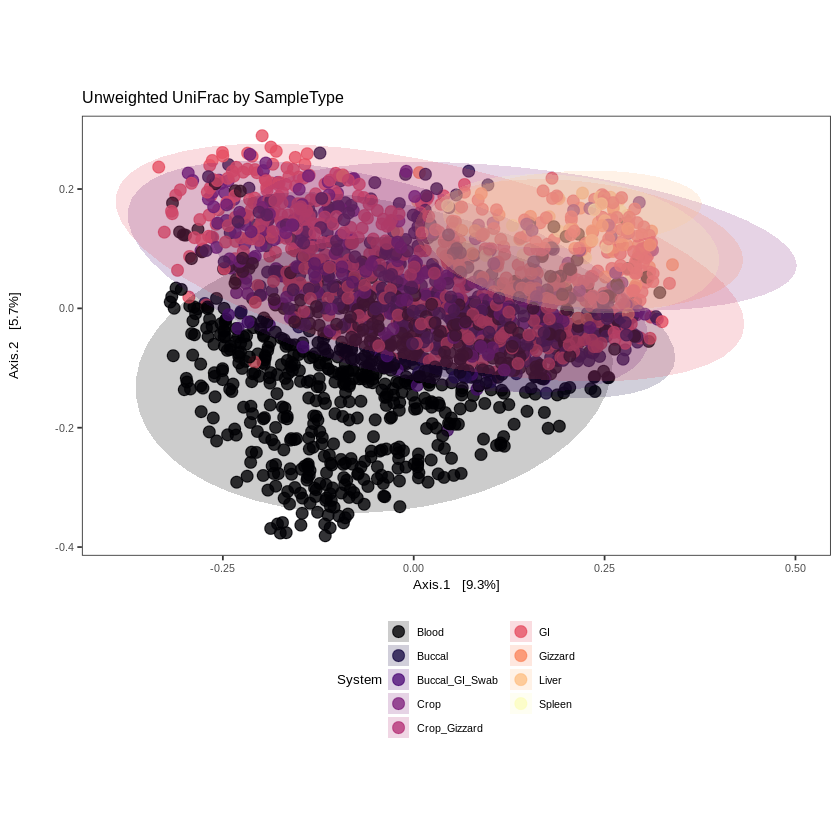

In [61]:
p = plot_ordination(bmp_t, bmp.unif.dist.log, color = "System") +#, shape = "System") + 
    ggtitle("Unweighted UniFrac by SampleType") +
    geom_point(size=3, alpha=0.8) + 
    scale_colour_viridis(option="magma", discrete=TRUE, direction=1) +
    stat_ellipse(level=0.95, geom="polygon",alpha = .2, aes(fill = System), linetype=0) +
    scale_fill_viridis(option="magma", discrete=TRUE, direction=1)+
    coord_fixed(sqrt(bmp.unif.dist.evals[2] / bmp.unif.dist.evals[1]))

p = p + guides(colour = guide_legend(title = "System", ncol = 2, keywidth = 1, keyheight = 1))

p = p + theme_bw() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=8, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.ticks = element_blank(),
              #legend.key.size = unit(.1, "in"),
              #legend.spacing.x = unit(.01,"in"),
              legend.position = "bottom")

p$layers <- p$layers[-1]

p

png('/home/holutz/projects/BirdMP/Plots/nonrare.unifrac.sampletype.pcoa.png', width=6, height=5, units='in', res=600)
plot(p)
dev.off()

In [12]:
#Read in pre-calculated data
bmp.wunif.dist = readRDS("/home/holutz/projects/BirdMP/Bdiv/bmp.wunif.dist.rds")
bmp.wunif.dist.log = readRDS("/home/holutz/projects/BirdMP/Bdiv/bmp.wunif.dist.log.rds")
bmp.wunif.dist.evals = readRDS("/home/holutz/projects/BirdMP/Bdiv/bmp.wunif.dist.evals.rds")

Too few points to calculate an ellipse

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Too few points to calculate an ellipse

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


png 
  2

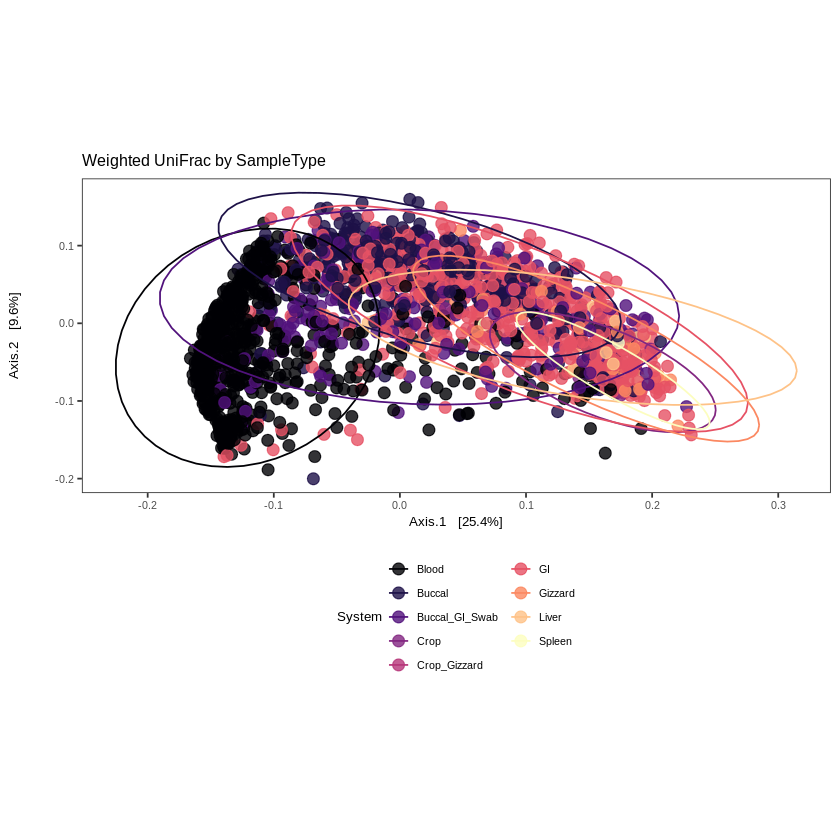

In [13]:
p = plot_ordination(bmp_t, bmp.wunif.dist.log, color = "System") +#, shape = "System") + 
    ggtitle("Weighted UniFrac by SampleType") +
    geom_point(size=3, alpha=0.8) + 
    scale_colour_viridis(option="magma", discrete=TRUE, direction=1) +
    stat_ellipse(level=0.95) +
    scale_fill_viridis(option="magma", discrete=TRUE, direction=1)+
    coord_fixed(sqrt(bmp.wunif.dist.evals[2] / bmp.wunif.dist.evals[1]))

p = p + guides(colour = guide_legend(title = "System", ncol = 2, keywidth = 1, keyheight = 1))

p = p + theme_bw() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=8, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.ticks = element_blank(),
              #legend.key.size = unit(.1, "in"),
              #legend.spacing.x = unit(.01,"in"),
              legend.position = "bottom")

p$layers <- p$layers[-1]

p

png('/home/holutz/projects/BirdMP/Plots/nonrare.wunifrac.sampletype.pcoa.png', width=6, height=5, units='in', res=600)
plot(p)
dev.off()

#### Relative Abundance

In [6]:
blood = subset_samples(bmp_nt, System=="Blood")
blood.rare = rarefy_even_depth(blood, sample.size = 1000)
blood.rare = blood.rare %>%
    transform_sample_counts(function(x) x / sum(x))   

You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`


...

21 samples removedbecause they contained fewer reads than `sample.size`.

Up to first five removed samples are: 


20762065246824761811

...

31137OTUs were removed because they are no longer 
present in any sample after random subsampling


...



In [7]:
blood
blood.rare

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 37178 taxa and 727 samples ]
sample_data() Sample Data:       [ 727 samples by 41 sample variables ]
tax_table()   Taxonomy Table:    [ 37178 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 37178 tips and 37176 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6041 taxa and 706 samples ]
sample_data() Sample Data:       [ 706 samples by 41 sample variables ]
tax_table()   Taxonomy Table:    [ 6041 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6041 tips and 6039 internal nodes ]

In [8]:
blood.rare.mdf = psmelt(blood.rare)

In [26]:
blood.rare.mdf <- blood.rare.mdf %>% mutate(
  Rank6_7 = paste(Rank6, Rank7, sep = "_")
)
colnames(blood.rare.mdf)

[1] "OTU"                        "Sample"                    
 [3] "Abundance"                  "X.SampleID"                
 [5] "BarcodeSequence"            "LinkerPrimerSequence"      
 [7] "Plate_name"                 "allplatesbarcodes_Tissue"  
 [9] "System"                     "System_gut_unique_GI_GI"   
[11] "System_gut_unique_GI_fecal" "SampleType"                
[13] "submitedsampename"          "Field_No1"                 
[15] "FMNH_no"                    "Sex"                       
[17] "Order"                      "Family"                    
[19] "Genus"                      "Species"                   
[21] "Species_name"               "Subspecies"                
[23] "COMMON_NAME"                "habitat_num"               
[25] "FIELD_SITE"                 "NEST_TYPE"                 
[27] "NEST_LOCATION"              "NESTING_HABITS"            
[29] "SOCIAL_SYSTEM"              "DIET"                      
[31] "Field40"                    "STRATA"                    
[33] "MIGRATORY_STATUS"           "SEXUAL_DIMORPHISM"         
[35] "Description"                "HaemoproteusHap"           
[37] "PlasmodiumHaplotype"        "LeucocytozoonHap"          
[39] "Uninfected"                 "CoinfectionHap"            
[41] "CoinfectionCode"            "COMBO"                     
[43] "HaemStatus"                 "InfectionStatus"           
[45] "Rank1"                      "Rank2"                     
[47] "Rank3"                      "Rank4"                     
[49] "Rank5"                      "Rank6"                     
[51] "Rank7"                      "Rank6_7"

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Selecting by m

`summarise()` regrouping output by 'Sample' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



png 
  2

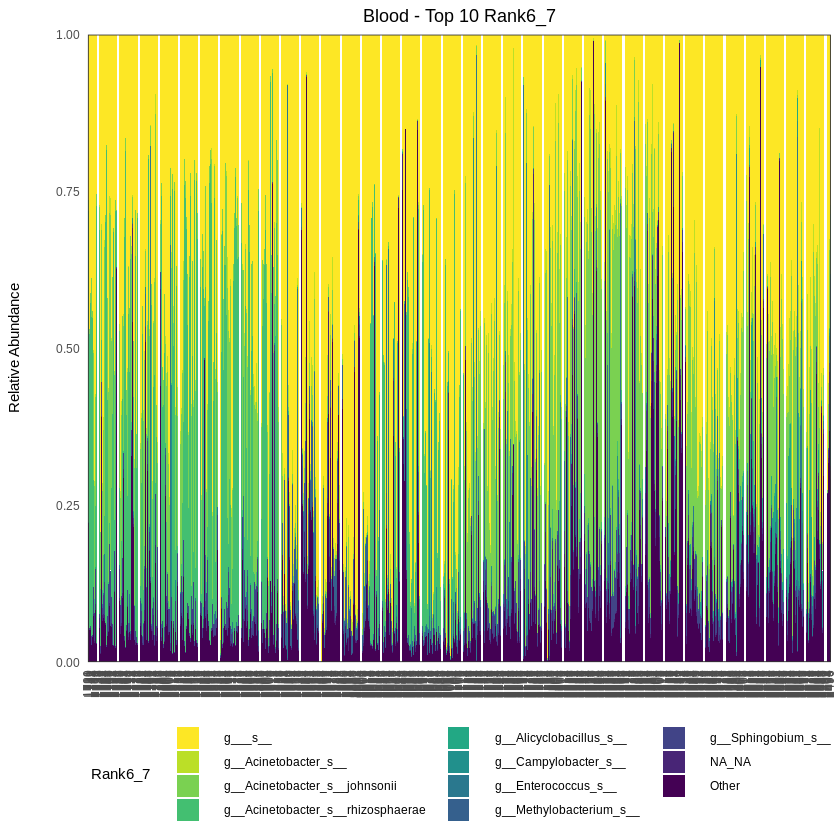

In [27]:
N = 10

topN = blood.rare.mdf %>%
    group_by(Rank6_7) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank6_7) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("Rank6_7")

mdfall.other = blood.rare.mdf %>%
    mutate(Rank6_7.other = ifelse(Rank6_7 %in% topN, as.character(Rank6_7), "Other")) %>%
    group_by(Sample, Rank6_7.other) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Abundance)

mdfall.summary = mdfall.other %>%
    group_by(Rank6_7.other) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              abundance = round(avg*100,2)) %>%
    arrange(Rank6_7.other)

p = ggplot(mdfall.other[order(mdfall.other$Rank6_7.other),], aes(x=Sample, y = Abundance, fill = Rank6_7.other))
                        
p = p + #facet_wrap(~Host_taxon, shrink = TRUE, scales = "free_x") +
    ylab("Relative Abundance")  +
    geom_bar(stat="identity") +
    scale_fill_viridis(option="viridis", discrete=TRUE, direction=-1) +
    scale_y_continuous(expand = c(0,0))

p = p + guides(fill = guide_legend(title = "Rank6_7", nrow = 4, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=9, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              axis.text.x=element_text(angle=90,vjust=0.4),
              #legend.key.size = unit(.25, "mm"),
              legend.spacing.x = unit(.2,"in"),
              axis.title.x=element_blank())

p = p + theme(legend.position="bottom") 

p = p + ggtitle("Blood - Top 10 Rank6_7") + theme(plot.title = element_text(hjust = 0.5))

p

png('/home/holutz/projects/BirdMP/Plots/blood.Rank6_7top10.png', width=25, height=12, units='in', res=500)
plot(p)
dev.off()

In [28]:
mdfall.summary

Rank6_7.other,avg,sd,sem,abundance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
g___s__,0.487290368,0.22446978,0.0084480317,48.73
g__Acinetobacter_s__,0.018903683,0.03553613,0.0013374197,1.89
g__Acinetobacter_s__johnsonii,0.165393768,0.16218166,0.0061037874,16.54
g__Acinetobacter_s__rhizosphaerae,0.111742210,0.20914060,0.0078711102,11.17
g__Alicyclobacillus_s__,0.008233711,0.03003809,0.0011304986,0.82
g__Campylobacter_s__,0.011947592,0.07339735,0.0027623455,1.19
g__Enterococcus_s__,0.025815864,0.10494707,0.0039497349,2.58
g__Methylobacterium_s__,0.008198300,0.02276791,0.0008568815,0.82
g__Sphingobium_s__,0.022637394,0.02299180,0.0008653079,2.26


### Blood Stuff

In [24]:
blood = subset_samples(bmp_nt, SampleType=="Blood")
blood = rarefy_even_depth(blood, sample.size=1000)
blood.df = data.frame(sample_data(blood))
blood.df %>% group_by(HaemStatus) %>% summarize(count=n())
blood.otu = data.frame(otu_table(blood))
blood.meta = data.frame(sample_data(blood))

You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`


...

21 samples removedbecause they contained fewer reads than `sample.size`.

Up to first five removed samples are: 


20762065246824761811

...

31047OTUs were removed because they are no longer 
present in any sample after random subsampling


...

`summarise()` ungrouping output (override with `.groups` argument)



HaemStatus,count
<fct>,<int>
Coinfection,83
Haemoproteus,84
Leucocytozoon,56
Plasmodium,77
Uninfected,406


In [15]:
obs = estimate_richness(blood, split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)
obs[] <- lapply(obs, gsub, pattern='X', replacement='') #Remove X from SampleID name

sample_tab = data.frame(sample_data(blood))
names(sample_tab)[1] = "SampleID"

dfobs = merge(obs, sample_tab, on="SampleID")
dfobs$Observed = as.integer(dfobs$Observed)

stats = dfobs %>%
    group_by(HaemStatus) %>%
    summarize(median = median(Observed), 
              mean = mean(Observed),
              sd = sd(Observed),
              sem = sd(Observed/sqrt(length(Observed)))) %>%
    arrange(-desc(HaemStatus))
stats

stats.krusk = kruskal.test(Observed~HaemStatus, data=dfobs)
stats.krusk

dunn = dunn.test(dfobs$Observed, g=dfobs$HaemStatus, method="bonferroni")
dunn

`summarise()` ungrouping output (override with `.groups` argument)



HaemStatus,median,mean,sd,sem
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Coinfection,78.0,83.24419,47.03864,5.072307
Haemoproteus,77.0,95.80000,69.29763,7.516384
Leucocytozoon,78.5,78.74138,40.38219,5.302442
Plasmodium,78.0,89.40506,51.66274,5.812513
Uninfected,84.0,101.92124,71.46067,3.491082



	Kruskal-Wallis rank sum test

data:  Observed by HaemStatus
Kruskal-Wallis chi-squared = 10.192, df = 4, p-value = 0.03731


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 10.1922, df = 4, p-value = 0.04


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |   Coinfect   Haemopro   Leucocyt   Plasmodi
---------+--------------------------------------------
Haemopro |  -0.763964
         |     1.0000
         |
Leucocyt |   0.342660   1.027920
         |     1.0000     1.0000
         |
Plasmodi |  -0.658104   0.091418  -0.929822
         |     1.0000     1.0000     1.0000
         |
Uninfect |  -2.272221  -1.278980  -2.335572  -1.356896
         |     0.1154     1.0000     0.0976     0.8741

alpha = 0.05
Reject Ho if p <= alpha/2


$chi2
[1] 10.19219

$Z
 [1] -0.76396494  0.34266017  1.02792088 -0.65810426  0.09141819 -0.92982257
 [7] -2.27222196 -1.27898084 -2.33557282 -1.35689614

$P
 [1] 0.222444067 0.365927065 0.151993523 0.255235569 0.463580154 0.176231479
 [7] 0.011536554 0.100451901 0.009756758 0.087407106

$P.adjusted
 [1] 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000 1.00000000
 [7] 0.11536554 1.00000000 0.09756758 0.87407106

$comparisons
 [1] "Coinfection - Haemoproteus"   "Coinfection - Leucocytozoon" 
 [3] "Haemoproteus - Leucocytozoon" "Coinfection - Plasmodium"    
 [5] "Haemoproteus - Plasmodium"    "Leucocytozoon - Plasmodium"  
 [7] "Coinfection - Uninfected"     "Haemoproteus - Uninfected"   
 [9] "Leucocytozoon - Uninfected"   "Plasmodium - Uninfected"

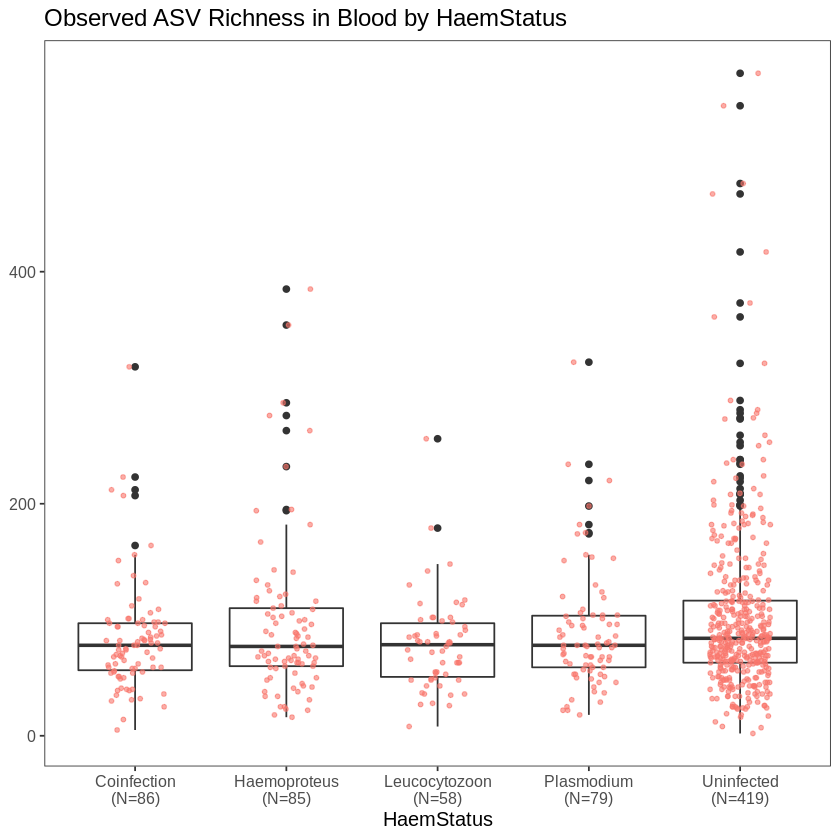

In [25]:
xlabs <- paste(levels(dfobs$HaemStatus),"\n(N=",table(dfobs$HaemStatus),")",sep="")

p = ggplot(dfobs, aes(x = HaemStatus, y = Observed), ) + ggtitle("Observed ASV Richness in Blood by HaemStatus")

p = p + geom_boxplot() + ylab("# of Observed ASVs") + scale_x_discrete(labels=xlabs) #+ coord_flip()

p = p + geom_point(size = 1, alpha = 0.6, aes(color = SampleType),  
                   position = position_jitter(h = 0, w = 0.2))

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Arial"),
                           legend.key = element_blank(),
                           legend.position = "none",
                           axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())
p

In [26]:
sha = estimate_richness(blood, split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)
#sha[] <- lapply(sha, gsub, pattern='X', replacement='') #Remove X from SampleID name

sample_tab = data.frame(sample_data(blood))
names(sample_tab)[1] = "SampleID"

dfsha = merge(sha, sample_tab, on="SampleID")
#dfsha$Shannon = as.integer(dfsha$Shannon)

stats = dfsha %>%
    group_by(HaemStatus) %>%
    summarize(median = median(Shannon), 
              mean = mean(Shannon),
              sd = sd(Shannon),
              sem = sd(Shannon/sqrt(length(Shannon)))) %>%
    arrange(-desc(HaemStatus))
stats

stats.krusk = kruskal.test(Shannon~HaemStatus, data=dfsha)
stats.krusk

dunn = dunn.test(dfsha$Shannon, g=dfsha$HaemStatus, method="bonferroni")
dunn

`summarise()` ungrouping output (override with `.groups` argument)



HaemStatus,median,mean,sd,sem
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Coinfection,1.669729,1.680586,0.5613338,0.06161439
Haemoproteus,1.581016,1.636493,0.6577848,0.07177020
Leucocytozoon,1.662387,1.601972,0.5110687,0.06829442
Plasmodium,1.724786,1.746829,0.5450477,0.06211395
Uninfected,1.751928,1.768262,0.6448502,0.03200338



	Kruskal-Wallis rank sum test

data:  Shannon by HaemStatus
Kruskal-Wallis chi-squared = 5.4465, df = 4, p-value = 0.2445


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 5.4465, df = 4, p-value = 0.24


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |   Coinfect   Haemopro   Leucocyt   Plasmodi
---------+--------------------------------------------
Haemopro |   0.788903
         |     1.0000
         |
Leucocyt |   0.566298  -0.140077
         |     1.0000     1.0000
         |
Plasmodi |  -0.361536  -1.136459  -0.883330
         |     1.0000     1.0000     1.0000
         |
Uninfect |  -0.923787  -1.946997  -1.467655  -0.435064
         |     1.0000     0.2577     0.7110     1.0000

alpha = 0.05
Reject Ho if p <= alpha/2


$chi2
[1] 5.446544

$Z
 [1]  0.7889035  0.5662982 -0.1400778 -0.3615361 -1.1364596 -0.8833305
 [7] -0.9237878 -1.9469976 -1.4676558 -0.4350647

$P
 [1] 0.21508421 0.28559555 0.44429927 0.35884935 0.12788213 0.18852885
 [7] 0.17779840 0.02576751 0.07109887 0.33175775

$P.adjusted
 [1] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
 [8] 0.2576751 0.7109887 1.0000000

$comparisons
 [1] "Coinfection - Haemoproteus"   "Coinfection - Leucocytozoon" 
 [3] "Haemoproteus - Leucocytozoon" "Coinfection - Plasmodium"    
 [5] "Haemoproteus - Plasmodium"    "Leucocytozoon - Plasmodium"  
 [7] "Coinfection - Uninfected"     "Haemoproteus - Uninfected"   
 [9] "Leucocytozoon - Uninfected"   "Plasmodium - Uninfected"

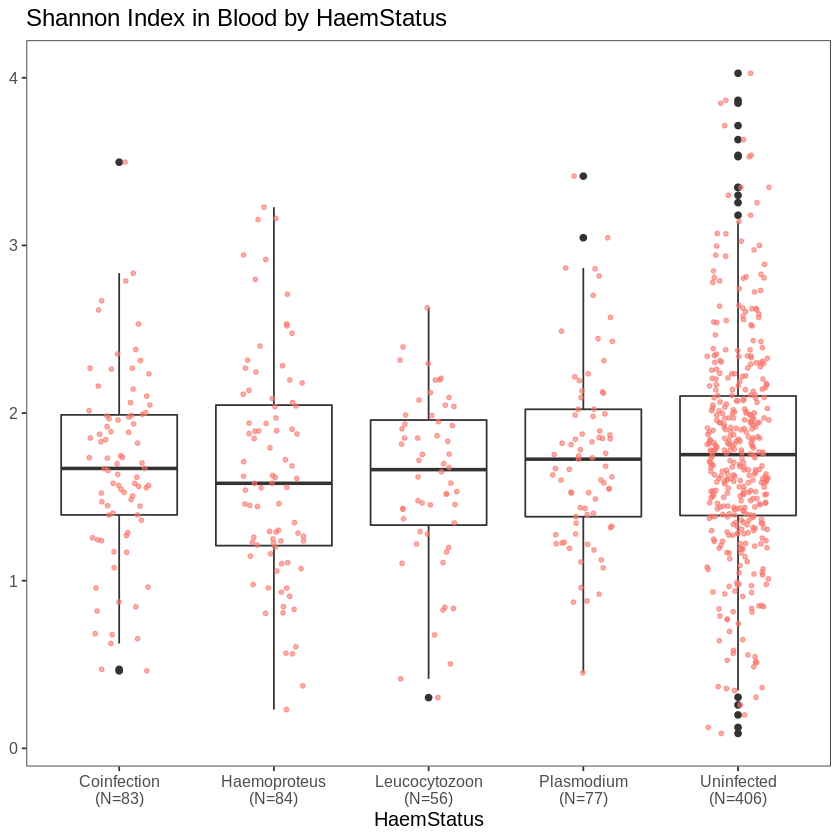

In [27]:
xlabs <- paste(levels(dfsha$HaemStatus),"\n(N=",table(dfsha$HaemStatus),")",sep="")

p = ggplot(dfsha, aes(x = HaemStatus, y = Shannon), ) + ggtitle("Shannon Index in Blood by HaemStatus")

p = p + geom_boxplot() + ylab("Shannon Index") + scale_x_discrete(labels=xlabs) #+ coord_flip()

p = p + geom_point(size = 1, alpha = 0.6, aes(color = SampleType),  
                   position = position_jitter(h = 0, w = 0.2))

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Arial"),
                           legend.key = element_blank(),
                           legend.position = "none",
                           axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())
p

### Gut Stuff

In [80]:
df = data.frame(sample_data(bmp_nt))
colnames(df)
df %>% group_by(System_gut_unique_GI_fecal) %>% summarize(count=n())
df %>% group_by(System_gut_unique_GI_GI) %>% summarize(count=n())

`summarise()` ungrouping output (override with `.groups` argument)



System_gut_unique_GI_fecal,count
<fct>,<int>
Unique_GI_fecal,433
NA,1576


`summarise()` ungrouping output (override with `.groups` argument)



System_gut_unique_GI_GI,count
<fct>,<int>
Unique_GI_GI,432
NA,1577


In [107]:
#Subset to maximize information while removing duplicates - choose one or the other for analysis
GI.fecal = subset_samples(bmp_nt.rare, System_gut_unique_GI_fecal=="Unique_GI_fecal")
GI.GI = subset_samples(bmp_nt.rare, System_gut_unique_GI_GI=="Unique_GI_GI")

#### Observed richness estimates

In [108]:
obs = estimate_richness(GI.fecal, split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)
obs[] <- lapply(obs, gsub, pattern='X', replacement='') #Remove X from SampleID name

sample_tab = data.frame(sample_data(GI.fecal))
names(sample_tab)[1] = "SampleID"

dfobs = merge(obs, sample_tab, on="SampleID")
dfobs$Observed = as.integer(dfobs$Observed)

In [109]:
stats = dfobs %>%
    group_by(InfectionStatus) %>%
    summarize(median = median(Observed), 
              mean = mean(Observed),
              sd = sd(Observed),
              sem = sd(Observed/sqrt(length(Observed)))) %>%
    arrange(-desc(InfectionStatus))
stats

`summarise()` ungrouping output (override with `.groups` argument)



InfectionStatus,median,mean,sd,sem
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Infected,39,56.11667,47.92417,4.374858
Uninfected,37,55.05806,53.92080,3.062496


In [113]:
stats.krusk = kruskal.test(Observed~HaemStatus, data=dfobs)
stats.krusk

dunn = dunn.test(dfobs$Observed, g=dfobs$HaemStatus, method="bonferroni")
dunn


	Kruskal-Wallis rank sum test

data:  Observed by HaemStatus
Kruskal-Wallis chi-squared = 9.9989, df = 4, p-value = 0.04045


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 9.9989, df = 4, p-value = 0.04


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |   Coinfect   Haemopro   Leucocyt   Plasmodi
---------+--------------------------------------------
Haemopro |  -2.068432
         |     0.1930
         |
Leucocyt |   0.800485   2.041801
         |     1.0000     0.2059
         |
Plasmodi |  -2.376532  -0.700474  -2.220020
         |     0.0874     1.0000     0.1321
         |
Uninfect |  -2.043438   0.317090  -2.005732   1.168270
         |     0.2050     1.0000     0.2244     1.0000

alpha = 0.05
Reject Ho if p <= alpha/2


$chi2
[1] 9.998866

$Z
 [1] -2.0684322  0.8004858  2.0418019 -2.3765323 -0.7004748 -2.2200204
 [7] -2.0434383  0.3170908 -2.0057328  1.1682700

$P
 [1] 0.019299702 0.211714688 0.020585594 0.008738116 0.241815431 0.013208691
 [7] 0.020504535 0.375587359 0.022442383 0.121348929

$P.adjusted
 [1] 0.19299702 1.00000000 0.20585594 0.08738116 1.00000000 0.13208691
 [7] 0.20504535 1.00000000 0.22442383 1.00000000

$comparisons
 [1] "Coinfection - Haemoproteus"   "Coinfection - Leucocytozoon" 
 [3] "Haemoproteus - Leucocytozoon" "Coinfection - Plasmodium"    
 [5] "Haemoproteus - Plasmodium"    "Leucocytozoon - Plasmodium"  
 [7] "Coinfection - Uninfected"     "Haemoproteus - Uninfected"   
 [9] "Leucocytozoon - Uninfected"   "Plasmodium - Uninfected"

In [111]:
#Sort by mean observed richness
avg_obs <- aggregate(Observed ~ COMBO, data = dfobs, mean)
dfobs$COMBO <-factor(dfobs$COMBO, levels=avg_obs[order(avg_obs$Observed), "COMBO"])

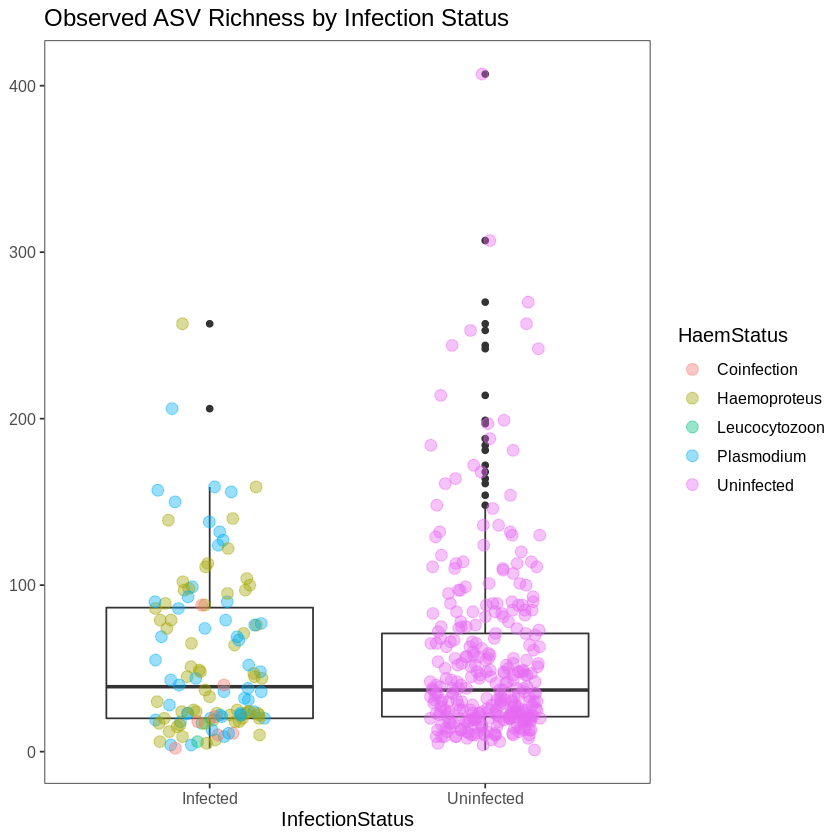

In [112]:
p = ggplot(dfobs, aes(x = InfectionStatus, y = Observed), ) + ggtitle("Observed ASV Richness by Infection Status")

p = p + geom_boxplot() + ylab("# of Observed ASVs") #+ coord_flip()

p = p + geom_point(size = 3, alpha = 0.4, aes(color = HaemStatus),  
                   position = position_jitter(h = 0, w = 0.2))

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Arial"),
                           legend.key = element_blank(),
                           legend.position = "right",
                           axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())
p

In [117]:
colnames(df)

[1] "X.SampleID"                 "BarcodeSequence"           
 [3] "LinkerPrimerSequence"       "Plate_name"                
 [5] "allplatesbarcodes_Tissue"   "System"                    
 [7] "System_gut_unique_GI_GI"    "System_gut_unique_GI_fecal"
 [9] "SampleType"                 "submitedsampename"         
[11] "Field_No1"                  "FMNH_no"                   
[13] "Sex"                        "Order"                     
[15] "Family"                     "Genus"                     
[17] "Species"                    "Species_name"              
[19] "Subspecies"                 "COMMON_NAME"               
[21] "habitat_num"                "FIELD_SITE"                
[23] "NEST_TYPE"                  "NEST_LOCATION"             
[25] "NESTING_HABITS"             "SOCIAL_SYSTEM"             
[27] "DIET"                       "Field40"                   
[29] "STRATA"                     "MIGRATORY_STATUS"          
[31] "SEXUAL_DIMORPHISM"          "Description"               
[33] "HaemoproteusHap"            "PlasmodiumHaplotype"       
[35] "LeucocytozoonHap"           "Uninfected"                
[37] "CoinfectionHap"             "CoinfectionCode"           
[39] "COMBO"

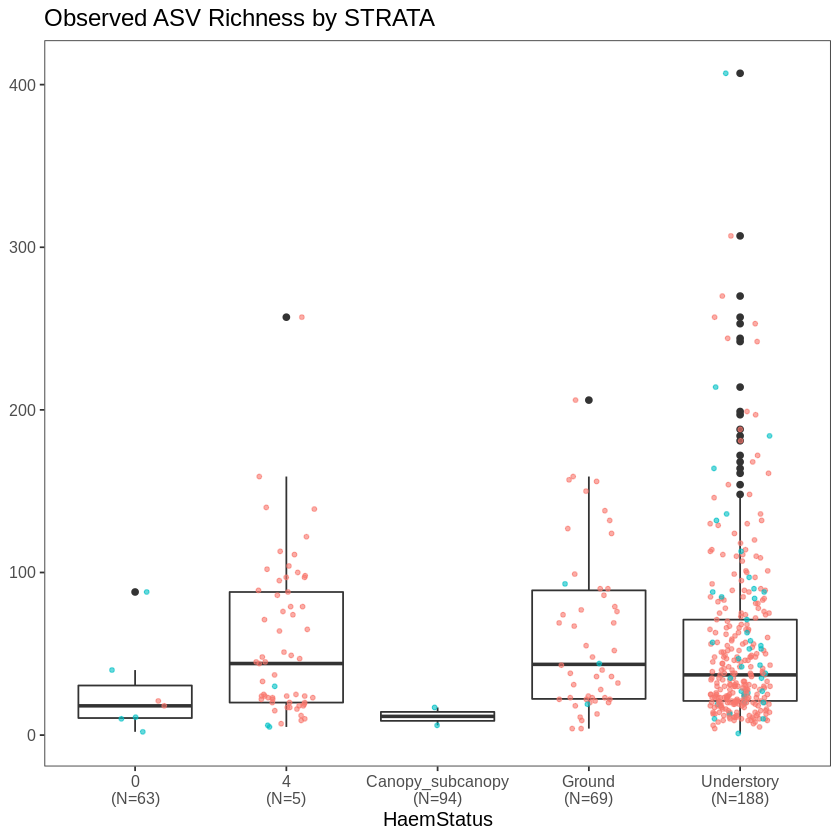

In [118]:
xlabs <- paste(levels(dfobs$STRATA),"\n(N=",table(dfobs$STRATA),")",sep="")

p = ggplot(dfobs, aes(x = HaemStatus, y = Observed), ) + ggtitle("Observed ASV Richness by STRATA")

p = p + geom_boxplot() + ylab("# of Observed ASVs") + scale_x_discrete(labels=xlabs) #+ coord_flip()

p = p + geom_point(size = 1, alpha = 0.6, aes(color = SampleType),  
                   position = position_jitter(h = 0, w = 0.2))

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Arial"),
                           legend.key = element_blank(),
                           legend.position = "none",
                           axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())
p